In [3]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import itertools
import yfinance as yf
import seaborn as sn
from IPython.core.display import display, HTML
from trend_following import (jupyter_interactive_mode, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices)
from strategy_performance_metrics import sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
jupyter_interactive_mode()

## Helper functions to help pull the data and run the analysis

## Pull the data from Yahoo Finance

We begin by pulling daily data for the specified instrument using the Yahoo finance API. The data available only goes back to late 2017. 

In [5]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2023, 12, 31)
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['TSLA']
data = get_close_prices(start_date, end_date, ticker)

File data found...reading ['BCH-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'BNB-USD', 'BTC-USD'] data


In [6]:
def calculate_ts_momentum(df, close_px_col, lookback_period, period_name, returns_type='arithmetic'):
    
    if returns_type == 'logarithmic':
        df[f'{close_px_col}_log_returns'] = np.log(df[close_px_col]/df[close_px_col].shift(1))
        df[f'{close_px_col}_{period_name}_momentum'] = df[f'{close_px_col}_log_returns'].rolling(window=lookback_period).sum()
    elif returns_type == 'arithmetic':
        df[f'{close_px_col}_pct_returns'] = df[f'{close_px_col}'].pct_change()
        df[f'{close_px_col}_{period_name}_momentum'] = df[f'{close_px_col}_pct_returns'].rolling(window=lookback_period).sum()
    
    return df

## THIS IS NON-COMPOUNDED RETURNS
def calculate_cumulative_returns(df, close_px_col, returns_type='logarithmic'):
    
    if returns_type == 'logarithmic':
        df[f'{close_px_col}_log_returns'] = np.log(df[close_px_col]/df[close_px_col].shift(1))
        df[f'{close_px_col}_log_cum_returns'] = df[f'{close_px_col}_log_returns'].cumsum()
    elif returns_type == 'arithmetic':
        df[f'{close_px_col}_pct_returns'] = df[f'{close_px_col}'].pct_change()
        df[f'{close_px_col}_pct_cum_returns'] = df[f'{close_px_col}_pct_returns'].cumsum()
    
    return df

In [7]:
def get_long_and_short_term_momentum(df, close_px_col, returns_type, weekend_trading=False):
    
    if weekend_trading:
        trading_lookback_periods = [10, 21, 63, 126, 252]
    else:
        trading_lookback_periods = [10, 30, 90, 180, 365]
        
    lookback_period_names = ['10_day', '1_month', '3_month', '6_month', '12_month']
    
    c = 0
    for lookback in trading_lookback_periods:
        df = calculate_ts_momentum(df, close_px_col, lookback_period=lookback, period_name=lookback_period_names[c], returns_type=returns_type)
        c+=1
    
    return df

In [8]:
def generate_momentum_signal(df, ticker, momentum_type, threshold):#, include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    df[f'{ticker}_{momentum_type}_signal'] = np.where(df[f'{ticker}_{momentum_type}'] > threshold, 1,
                                             np.where(df[f'{ticker}_{momentum_type}'] < -threshold, -1, np.nan))
    df[f'{ticker}_{momentum_type}_signal'] = df[f'{ticker}_{momentum_type}_signal'].shift(1)
    
    df[f'{ticker}_daily_returns'] = df[f'{ticker}'].pct_change()
    
#     if include_transaction_costs_and_fees:
#         average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
#         df[f'{ticker}_{momentum_type}_strategy_returns'] = (df[f'{ticker}_{momentum_type}_signal'] * df[f'{ticker}_daily_returns'] -
#                                                             (transaction_cost_est + average_fee_per_trade))
#     else:
    df[f'{ticker}_{momentum_type}_strategy_returns'] = df[f'{ticker}_{momentum_type}_signal'] * df[f'{ticker}_daily_returns']
    df[f'{ticker}_{momentum_type}_strategy_trades'] = df[f'{ticker}_{momentum_type}_signal'].diff()
    
    # Calculate cumulative returns
    df[f'{ticker}_{momentum_type}_cum_strategy_returns'] = (1 + df[f'{ticker}_{momentum_type}_strategy_returns']).cumprod() - 1
    df[f'{ticker}_{momentum_type}_cum_buy_and_hold_returns'] = (1 + df[f'{ticker}_daily_returns']).cumprod() - 1
    
    return df

In [ ]:
def estimate_fee_per_trade(passive_trade_rate=0.5):
    ## Maker/Taker Fee based on lowest tier at Coinbase
    maker_fee = 0.006  # 0.6%
    taker_fee = 0.012  # 1.20%
    proportion_maker = passive_trade_rate
    proportion_taker = (1 - passive_trade_rate)

    average_fee_per_trade = (maker_fee * proportion_maker) + (taker_fee * proportion_taker)
    
    return average_fee_per_trade

In [ ]:
def calculate_drawdown(df, strategy_daily_return_col, strategy_trade_count_col, include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        adjusted_daily_returns = df[strategy_daily_return_col] - (np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade))
        df['strategy_cumulative_return'] = (1 + adjusted_daily_returns).cumprod() - 1
    else:
        df['strategy_cumulative_return'] = (1 + df[strategy_daily_return_col]).cumprod() - 1
    df[f'strategy_cumulative_return_cum_max'] = df['strategy_cumulative_return'].cummax()
    df[f'strategy_cumulative_return_drawdown'] = df['strategy_cumulative_return'] - df[f'strategy_cumulative_return_cum_max']
    df[f'strategy_cumulative_return_drawdown_pct'] = df[f'strategy_cumulative_return_drawdown'] / df[f'strategy_cumulative_return_cum_max']
    df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    
    # Calculate maximum drawdown
    max_drawdown = df[f'strategy_cumulative_return_drawdown_pct'].min()
    
    # Calculate maximum drawdown duration
    df['End'] = df.index
    df['Start'] = df[f'strategy_cumulative_return_cum_max'].ne(df[f'strategy_cumulative_return_cum_max'].shift(1)).cumsum()
    df[f'strategy_cumulative_return_DDDuration'] = df.groupby('Start')['End'].transform(lambda x: x.max() - x.min())
    max_drawdown_duration = df[f'strategy_cumulative_return_DDDuration'].max()

    # Drop NaN values for better display
#     df = df.dropna(inplace=True)
    return df, max_drawdown, max_drawdown_duration

In [ ]:
def calculate_compounded_cumulative_returns(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days=252, include_transaction_costs_and_fees=True,
                                            transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Calculate cumulative return
    df['strategy_cumulative_return'] = (1 + df[strategy_daily_return_col]).cumprod() - 1

    # Calculate the total cumulative return at the end of the period
    total_cumulative_return = df['strategy_cumulative_return'].iloc[-1]

    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        num_trades = np.abs(df[strategy_trade_count_col]).sum()
        total_transaction_cost = num_trades * transaction_cost_est
        total_fee_cost = num_trades * average_fee_per_trade
        total_cumulative_return = total_cumulative_return - (total_transaction_cost + total_fee_cost)
    
    return total_cumulative_return

In [ ]:
def calculate_CAGR(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days=252, include_transaction_costs_and_fees=True,
                   transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Calculate cumulative return
    total_cumulative_return = calculate_compounded_cumulative_returns(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col,
                                                                     annual_trading_days=annual_trading_days, include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                                                     transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate CAGR
    # Calculate the number of periods (days)
    num_periods = len(df)

    # Convert the number of periods to years (assuming daily data, 252 trading days per year)
    trading_days_per_year = annual_trading_days
    num_years = num_periods / trading_days_per_year
    annualized_return = (1 + total_cumulative_return) ** (1 / num_years) - 1
    
    return annualized_return

In [ ]:
def calculate_calmar_ratio(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days=252, include_transaction_costs_and_fees=True,
                           transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Calculate CAGR
    cagr = calculate_CAGR(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days=annual_trading_days, 
                          include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                          transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Max Drawdown
    _, max_drawdown, _ = calculate_drawdown(df, strategy_daily_return_col, strategy_trade_count_col,
                                            include_transaction_costs_and_fees=include_transaction_costs_and_fees, 
                                            transaction_cost_est=transaction_cost_est, 
                                            passive_trade_rate=passive_trade_rate)
    
    # Calculate Calmar Ratio
    calmar_ratio = cagr / abs(max_drawdown)
    
    return calmar_ratio

In [ ]:
def calculate_hit_rate(df, strategy_daily_return_col, strategy_trade_count_col, include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5):
    
    # Identify profitable trades (daily returns > 0)
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        df['profitable_trade'] = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade)) > 0
    else:
        df['profitable_trade'] = df[strategy_daily_return_col] > 0

    # Calculate hit rate
    total_trades = df['profitable_trade'].count()
    profitable_trades = df['profitable_trade'].sum()
    hit_rate = profitable_trades / total_trades
    
    return hit_rate

In [ ]:
from scipy import stats
def calculate_t_stat(df, strategy_daily_return_col, strategy_trade_count_col, include_transaction_costs_and_fees=True, transaction_cost_est=0.001,
                    passive_trade_rate=0.5):
    
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        mean_return = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade)).mean()
        std_dev_return = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) * (transaction_cost_est + average_fee_per_trade)).std()
    else:
        mean_return = df[strategy_daily_return_col].mean()
        std_dev_return = df[strategy_daily_return_col].std()
        
    num_days = len(df[strategy_daily_return_col])
    t_stat = mean_return/(std_dev_return/np.sqrt(num_days))
    p_value = stats.t.sf(np.abs(t_stat), df=num_days-1) * 2
    
    return t_stat, p_value

In [ ]:
def calculate_annualized_std_dev(df, strategy_daily_return_col, strategy_trade_count_col, annual_trading_days, include_transaction_costs_and_fees=True, transaction_cost_est=0.001,
                                 passive_trade_rate=0.5):
    
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        annualized_std_dev = (df[strategy_daily_return_col] - np.abs(df[strategy_trade_count_col]) *
                              (transaction_cost_est + average_fee_per_trade)).std() * np.sqrt(annual_trading_days)
    else:
        annualized_std_dev = df[strategy_daily_return_col].std() * np.sqrt(annual_trading_days)
    
    return annualized_std_dev

In [ ]:
def calculate_risk_and_performance_metrics(df, strategy_daily_return_col, strategy_trade_count_col, annual_rf=0.05, annual_trading_days=252, include_transaction_costs_and_fees=True, transaction_cost_est=0.001,
                                           passive_trade_rate=0.5):
    
    # Calculate CAGR
    annualized_return = calculate_CAGR(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days,
                                       include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Annualized Sharpe Ratio
    annualized_sharpe_ratio = sharpe_ratio(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days, annual_rf=annual_rf,
                                           include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Calmar Ratio
    calmar_ratio = sharpe_ratio(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days, 
                                include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Annualized Standard Deviation
    annualized_std_dev = calculate_annualized_std_dev(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, annual_trading_days=annual_trading_days,
                                                      include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Max Drawdown
    df, max_drawdown, max_drawdown_duration = calculate_drawdown(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, 
                                                                 include_transaction_costs_and_fees=include_transaction_costs_and_fees, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate Hit Rate
    hit_rate = calculate_hit_rate(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                  transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Calculate T-Stat and P-Value
    t_stat, p_value = calculate_t_stat(df, strategy_daily_return_col=strategy_daily_return_col, strategy_trade_count_col=strategy_trade_count_col, include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                       transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
    
    # Count of trades
    total_num_trades = np.abs(df[strategy_trade_count_col]).sum()
    
    performance_metrics = {'annualized_return': annualized_return,
                           'annualized_sharpe_ratio': annualized_sharpe_ratio,
                           'calmar_ratio': calmar_ratio,
                           'annualized_std_dev': annualized_std_dev,
                           'max_drawdown': max_drawdown,
                           'max_drawdown_duration': max_drawdown_duration,
                           'hit_rate': hit_rate,
                           't_statistic': t_stat,
                           'p_value': p_value,
                           'trade_count': total_num_trades}
    
    return performance_metrics

In [9]:
ticker = '^VIX'
data_VIX = get_close_prices(start_date, end_date, ticker)

File data found...reading ['^VIX'] data


In [10]:
data_VIX.head()

,^VIX
Date,
2014-09-17,12.65
2014-09-18,12.03
2014-09-19,12.11
2014-09-22,13.69
2014-09-23,14.93


In [11]:
ticker_list = ['ETH-USD','XRP-USD','SOL-USD','BCH-USD','BTC-USD',]
momentum_strategy_list = ['10_day_momentum','1_month_momentum','3_month_momentum','6_month_momentum','12_month_momentum','12_month_minus_1_month_momentum']
threshold_list = [0.2] * len(momentum_strategy_list)
performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
final_perf_stats = []
for ticker in ticker_list:
    print(ticker)
    df_temp_results = pd.DataFrame(columns=performance_columns)
    for i in np.arange(len(momentum_strategy_list)):
        data = get_close_prices(start_date, end_date, ticker)
        data = get_long_and_short_term_momentum(data, close_px_col=ticker, returns_type='logarithmic', weekend_trading=True)
        data[f'{ticker}_12_month_minus_1_month_momentum'] = data[f'{ticker}_12_month_momentum'] - data[f'{ticker}_1_month_momentum']
        data = generate_momentum_signal(data, ticker=ticker, momentum_type=momentum_strategy_list[i], threshold=threshold_list[i])
        data = data.dropna()
        metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_returns',
                                                         strategy_trade_count_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_trades', annual_trading_days=365,
                                                         include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)
        df_temp_results.loc[f'{ticker}_{momentum_strategy_list[i]}_strategy_returns'] = metrics
    
    final_perf_stats.append(df_temp_results)

df_final = pd.concat(final_perf_stats, axis=0)

ETH-USD
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
File data found...reading ['ETH-USD'] data
XRP-USD
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
File data found...reading ['XRP-USD'] data
SOL-USD
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
File data found...reading ['SOL-USD'] data
BCH-USD
File data found...reading ['BCH-USD'] data
File data found...reading ['BCH-USD'] data
File data found...reading ['BCH-USD'] data
File data found...reading ['BCH-USD'] data
File data found...read

In [ ]:
df_final

In [ ]:
data.head()

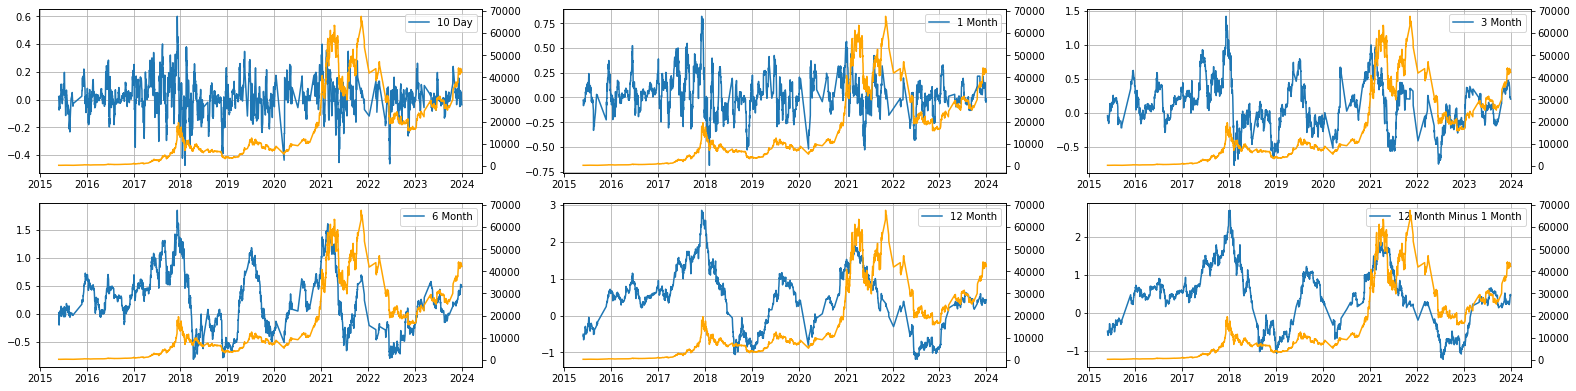

In [12]:
ticker = 'BTC-USD'
fig = plt.figure(figsize=(22,8))
# plt.style.use('bmh')
layout = (3,3)
momentum_ax_1 = plt.subplot2grid(layout, (0,0))#, colspan=2)
momentum_ax_2 = plt.subplot2grid(layout, (0,1))#, colspan=2)
momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
momentum_ax_4 = plt.subplot2grid(layout, (1,0))#, colspan=2)
momentum_ax_5 = plt.subplot2grid(layout, (1,1))#, colspan=2)
momentum_ax_6 = plt.subplot2grid(layout, (1,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

momentum_twin_ax_1 = momentum_ax_1.twinx()
_ = momentum_ax_1.plot(data.index, data[f'{ticker}_10_day_momentum'], label='10 Day')
_ = momentum_twin_ax_1.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_2 = momentum_ax_2.twinx()
_ = momentum_ax_2.plot(data.index, data[f'{ticker}_1_month_momentum'], label='1 Month')
_ = momentum_twin_ax_2.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_3 = momentum_ax_3.twinx()
_ = momentum_ax_3.plot(data.index, data[f'{ticker}_3_month_momentum'], label='3 Month')
_ = momentum_twin_ax_3.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_4 = momentum_ax_4.twinx()
_ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
_ = momentum_twin_ax_4.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_5 = momentum_ax_5.twinx()
_ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
_ = momentum_twin_ax_5.plot(data.index, data[ticker], label='Price', color='orange')

momentum_twin_ax_6 = momentum_ax_6.twinx()
_ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
_ = momentum_twin_ax_6.plot(data.index, data[ticker], label='Price', color='orange')

_ = momentum_ax_1.grid()
_ = momentum_ax_1.legend()
_ = momentum_ax_2.grid()
_ = momentum_ax_2.legend()
_ = momentum_ax_3.grid()
_ = momentum_ax_3.legend()
_ = momentum_ax_4.grid()
_ = momentum_ax_4.legend()
_ = momentum_ax_5.grid()
_ = momentum_ax_5.legend()
_ = momentum_ax_6.grid()
_ = momentum_ax_6.legend()

plt.tight_layout()

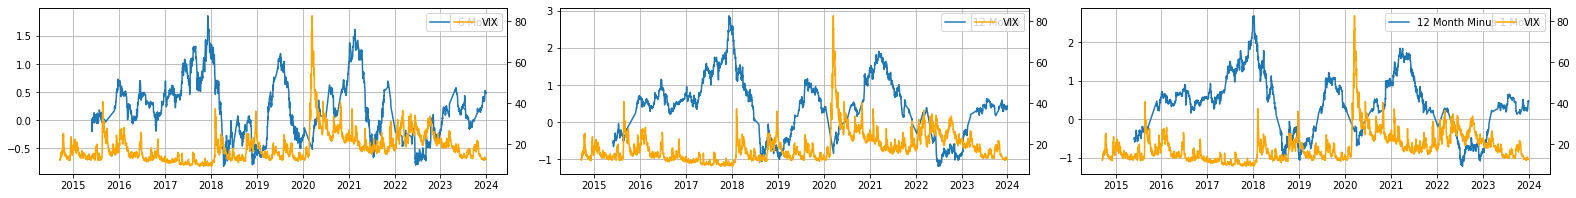

In [13]:
ticker = 'BTC-USD'
fig = plt.figure(figsize=(22,8))
# plt.style.use('bmh')
layout = (3,3)
# momentum_ax_1 = plt.subplot2grid(layout, (0,0))#, colspan=2)
# momentum_ax_2 = plt.subplot2grid(layout, (0,1))#, colspan=2)
# momentum_ax_3 = plt.subplot2grid(layout, (0,2))#, colspan=2)
momentum_ax_4 = plt.subplot2grid(layout, (0,0))#, colspan=2)
momentum_ax_5 = plt.subplot2grid(layout, (0,1))#, colspan=2)
momentum_ax_6 = plt.subplot2grid(layout, (0,2))#, colspan=2)
# pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

momentum_twin_ax_4 = momentum_ax_4.twinx()
_ = momentum_ax_4.plot(data.index, data[f'{ticker}_6_month_momentum'], label='6 Month')
_ = momentum_twin_ax_4.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

momentum_twin_ax_5 = momentum_ax_5.twinx()
_ = momentum_ax_5.plot(data.index, data[f'{ticker}_12_month_momentum'], label='12 Month')
_ = momentum_twin_ax_5.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

momentum_twin_ax_6 = momentum_ax_6.twinx()
_ = momentum_ax_6.plot(data.index, data[f'{ticker}_12_month_minus_1_month_momentum'], label='12 Month Minus 1 Month')
_ = momentum_twin_ax_6.plot(data_VIX.index, data_VIX['^VIX'], label='VIX', color='orange')

# _ = momentum_ax_1.grid()
# _ = momentum_ax_1.legend()
# _ = momentum_ax_2.grid()
# _ = momentum_ax_2.legend()
# _ = momentum_ax_3.grid()
# _ = momentum_ax_3.legend()
_ = momentum_ax_4.grid()
_ = momentum_ax_4.legend()
_ = momentum_twin_ax_4.legend()
_ = momentum_ax_5.grid()
_ = momentum_ax_5.legend()
_ = momentum_twin_ax_5.legend()
_ = momentum_ax_6.grid()
_ = momentum_ax_6.legend()
_ = momentum_twin_ax_6.legend()

plt.tight_layout()

In [ ]:
data['BTC-USD_daily_returns'].corr(data_VIX['^VIX'])

In [ ]:
data.head()

In [ ]:
def generate_trend_signal(df, mavg_slope_col_list, ticker='BTC-USD'):
    
    def slope_signal(row):
        if all(row[i] <= row[i+1] for i in range(len(row) - 1)):
            return 'downtrend'
        elif all(row[i] >= row[i+1] for i in range(len(row) - 1)):
            return 'uptrend'
        
    df[f'{ticker}_trend_slope_signal'] = df[mavg_slope_col_list].apply(slope_signal, axis=1)

    return df

In [ ]:
for end in np.linspace(200, 600, 3):
    print(end)

In [ ]:
for end in np.arange(200, 1000, 50):
    for start in np.arange(10, end, 10):
        for stepsizes in np.arange(1,10,1):
            print(start, end, end/start*stepsizes)

In [ ]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2024, 7, 30)
ticker = ['BTC-USD']#,'ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['TSLA']
data = get_close_prices(start_date, end_date, ticker)

In [ ]:
mavg_start = 10
mavg_end = 100
mavg_stepsize = 2
ticker = 'BTC-USD'
data = create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')

In [ ]:
mavg_start = 30
mavg_end = 300
mavg_stepsize = 2
ticker = 'BTC-USD'
data = create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')

## Trend Signal Performance

In [75]:
from strategy_performance_metrics import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker, moving_avg_type='exponential', price_or_returns_calc='returns'):
    
    perf_cols = ['ticker', 'fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    fast_mavg_list = np.arange(10, 101, 10)
    slow_mavg_list = np.arange(50, 501, 50)
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg <= slow_mavg/2:
                    df = get_close_prices(start_date, end_date, ticker)
                    df = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=stepsize, slope_window=10, moving_avg_type=moving_avg_type,
                                                price_or_returns_calc=price_or_returns_calc)
                          .rename(columns={'BTC-USD_trend_strategy_returns': f'BTC-USD_trend_strategy_returns_{fast_mavg}_{stepsize}_{slow_mavg}',
                                           'BTC-USD_trend_strategy_trades': f'BTC-USD_trend_strategy_trades_{fast_mavg}_{stepsize}_{slow_mavg}'}))
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'BTC-USD_trend_strategy_returns_{fast_mavg}_{stepsize}_{slow_mavg}',
                                                                                strategy_trade_count_col=f'BTC-USD_trend_strategy_trades_{fast_mavg}_{stepsize}_{slow_mavg}')
                    row = {
                        'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio']
                    }
                    df_performance = df_performance.append(row, ignore_index=True)
    
    return df_performance

In [57]:
ticker = 'BTC-USD'
df_performance_returns = moving_avg_crossover_strategy_performance(start_date, end_date, ticker, moving_avg_type='exponential', price_or_returns_calc='returns')

File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data f

File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data f

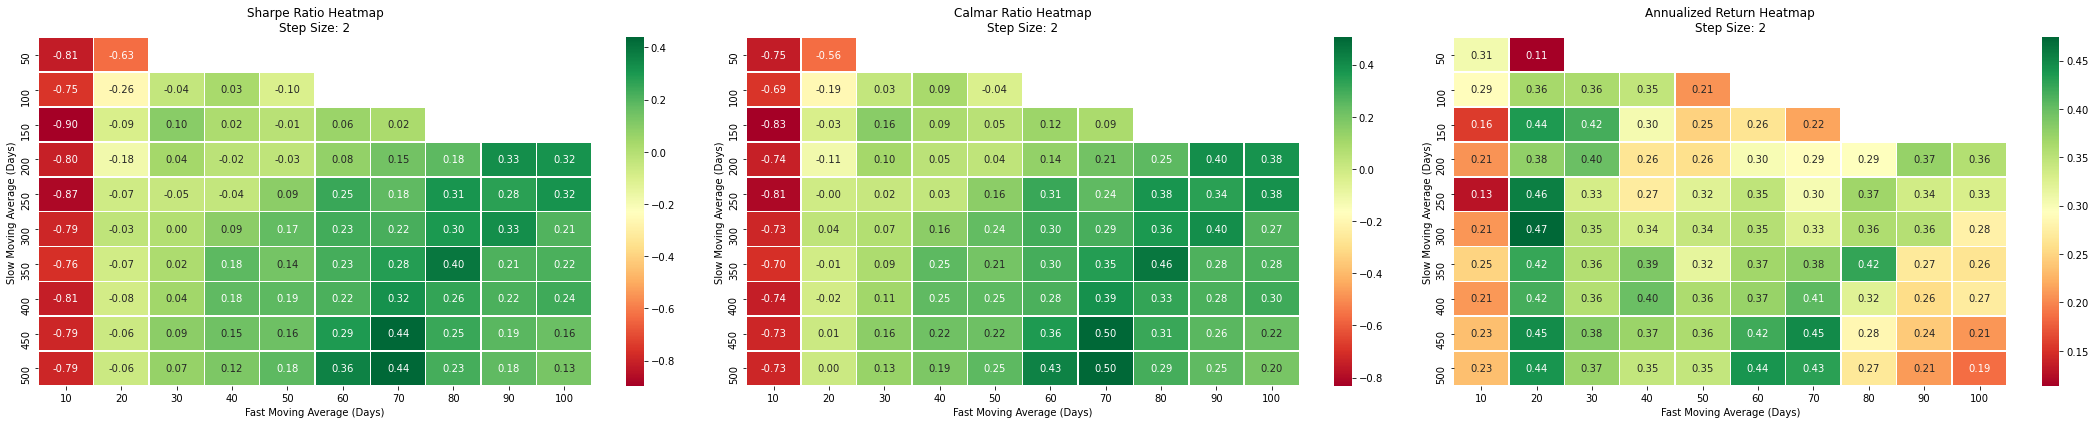

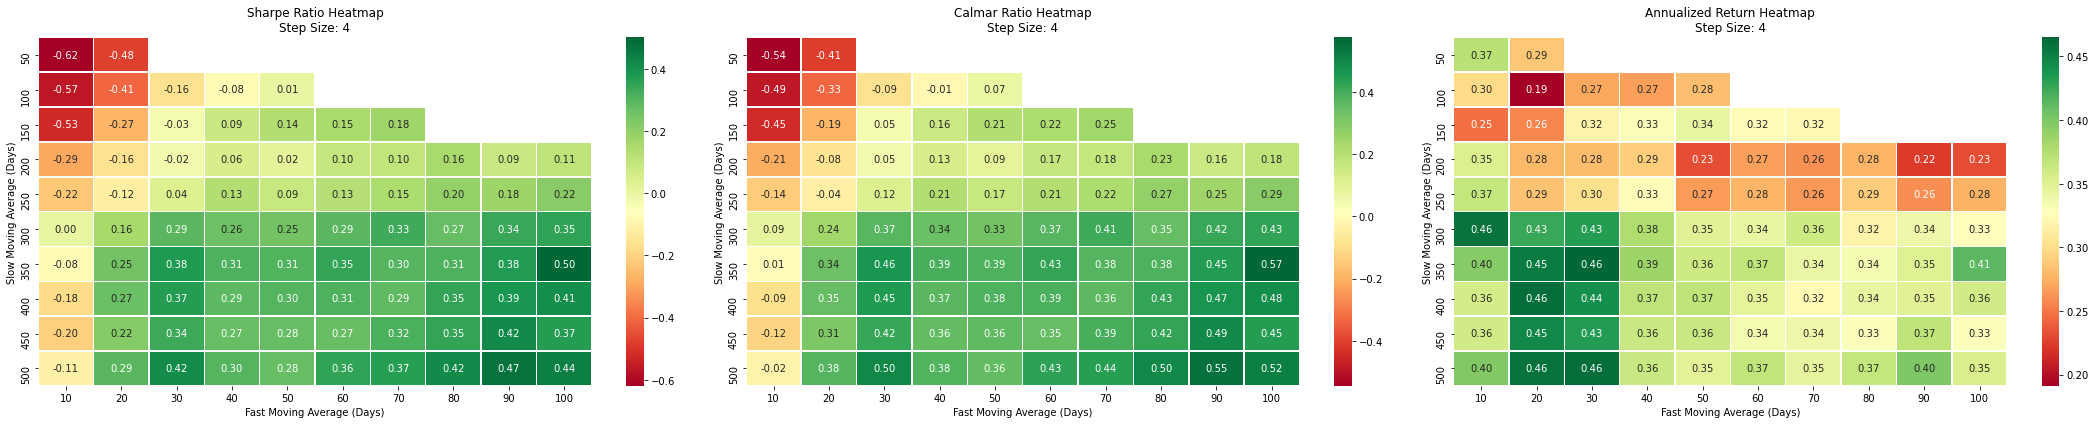

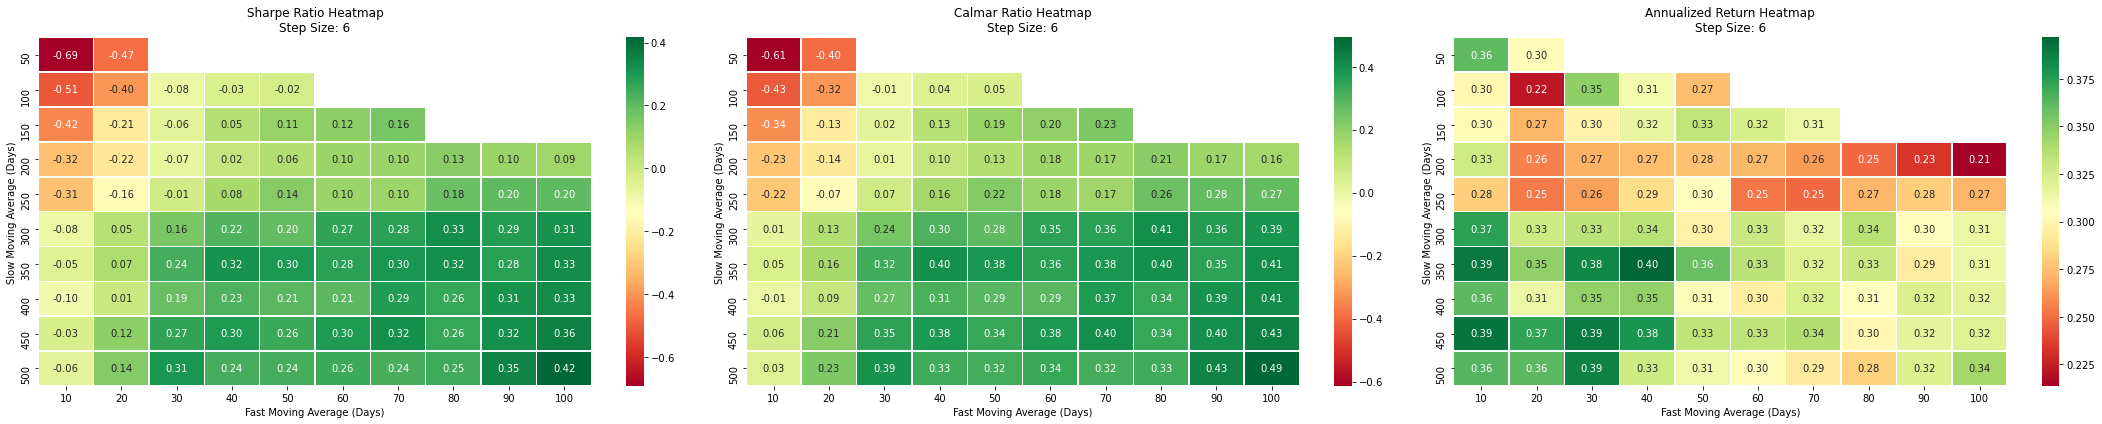

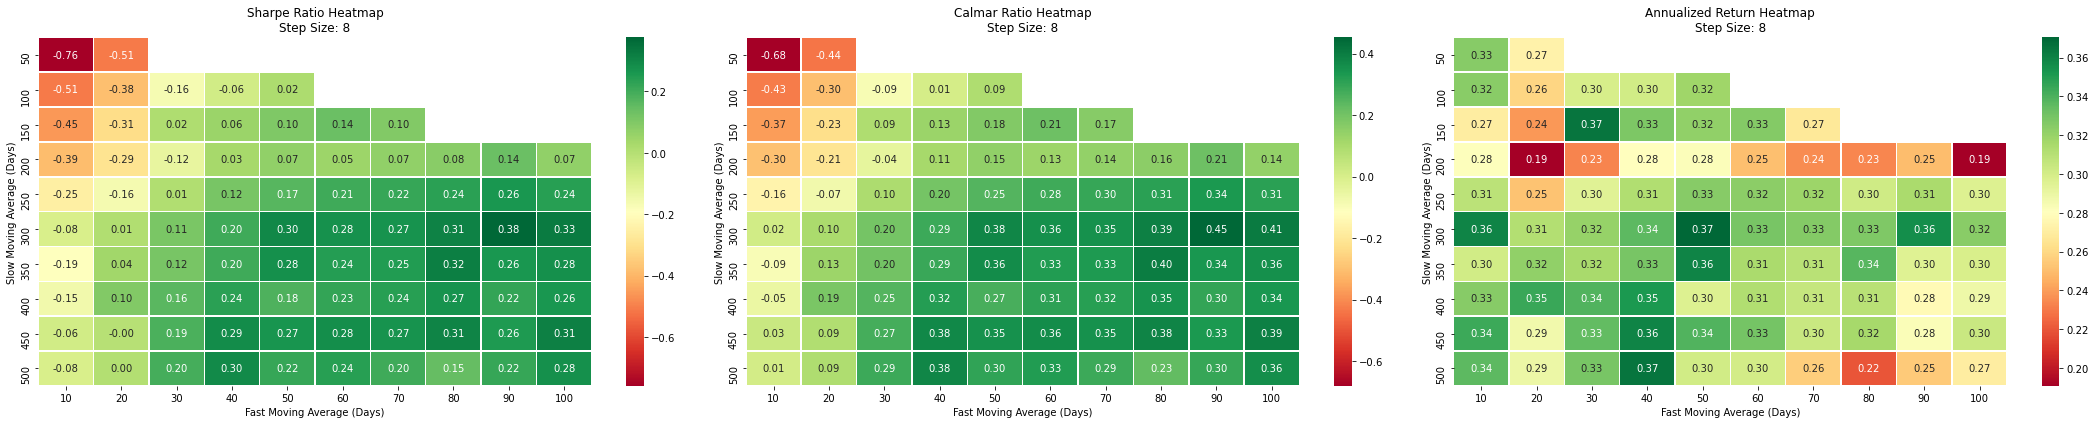

In [76]:
plot_moving_avg_crossover_performance(df_performance_returns)

In [59]:
ticker = 'BTC-USD'
df_performance_price = moving_avg_crossover_strategy_performance(start_date, end_date, ticker, moving_avg_type='exponential', price_or_returns_calc='price')

File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data f

File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data found...reading ['BTC-USD'] data
File data f

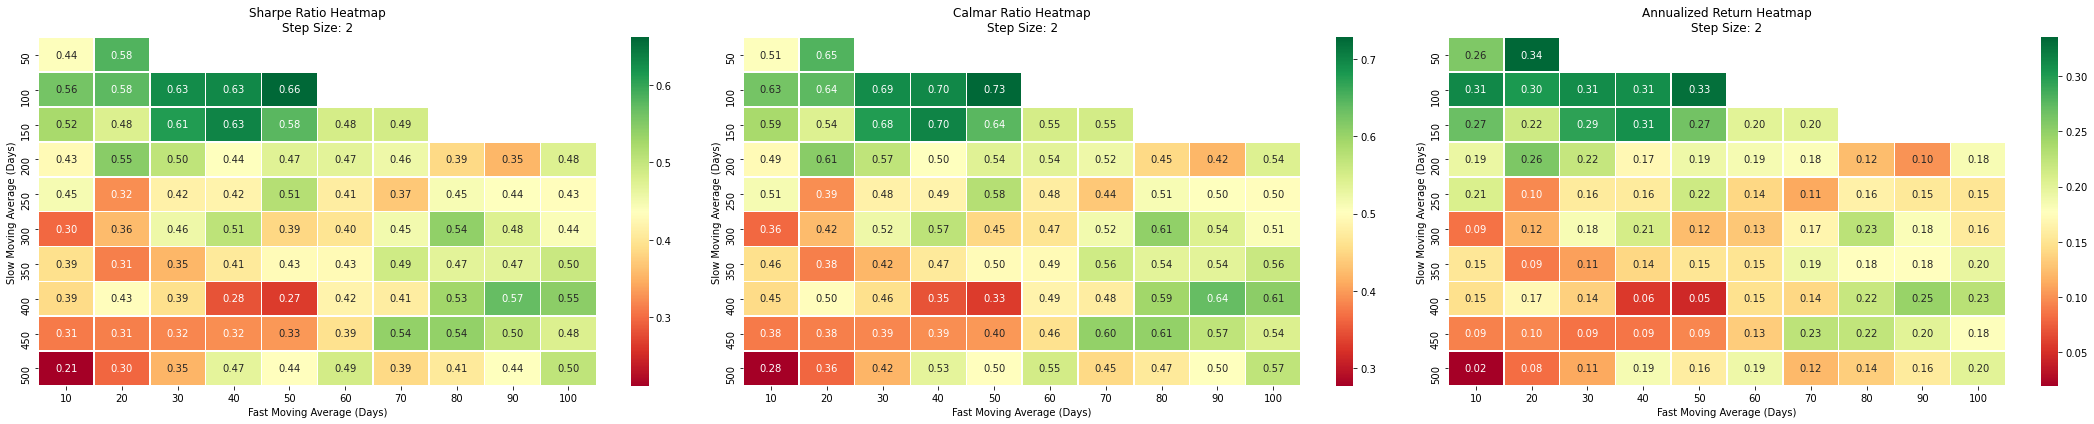

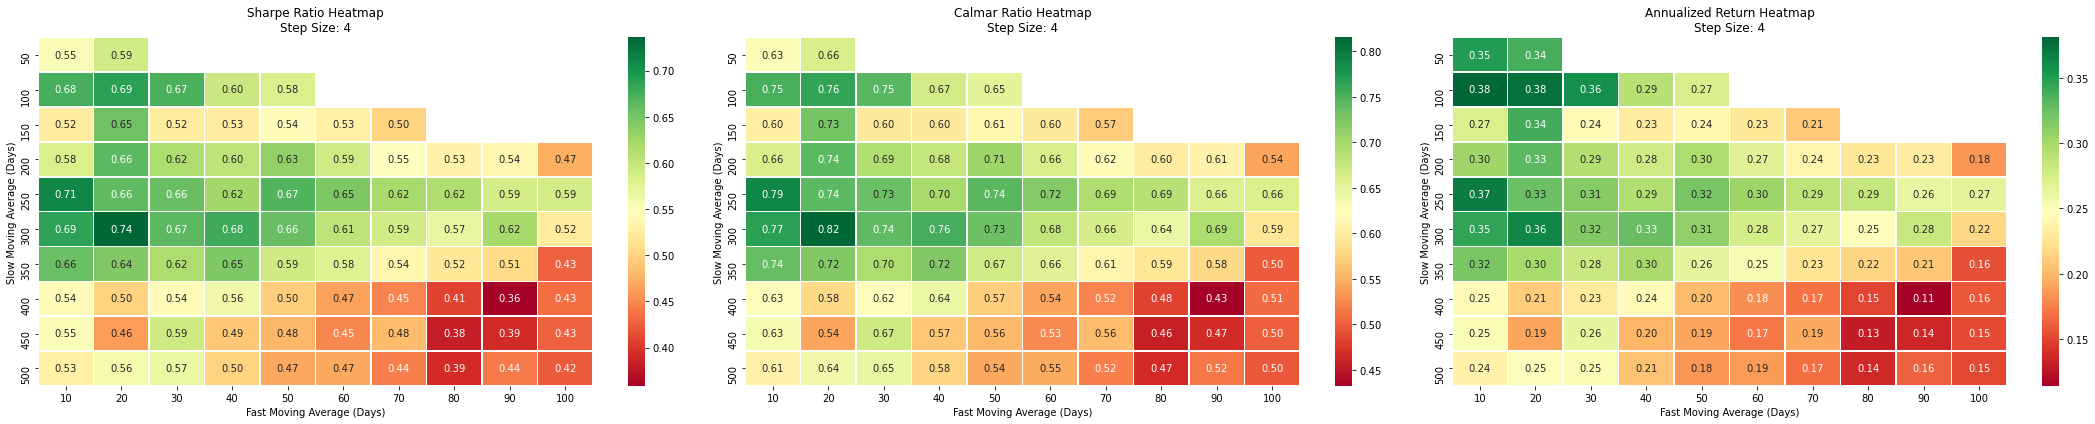

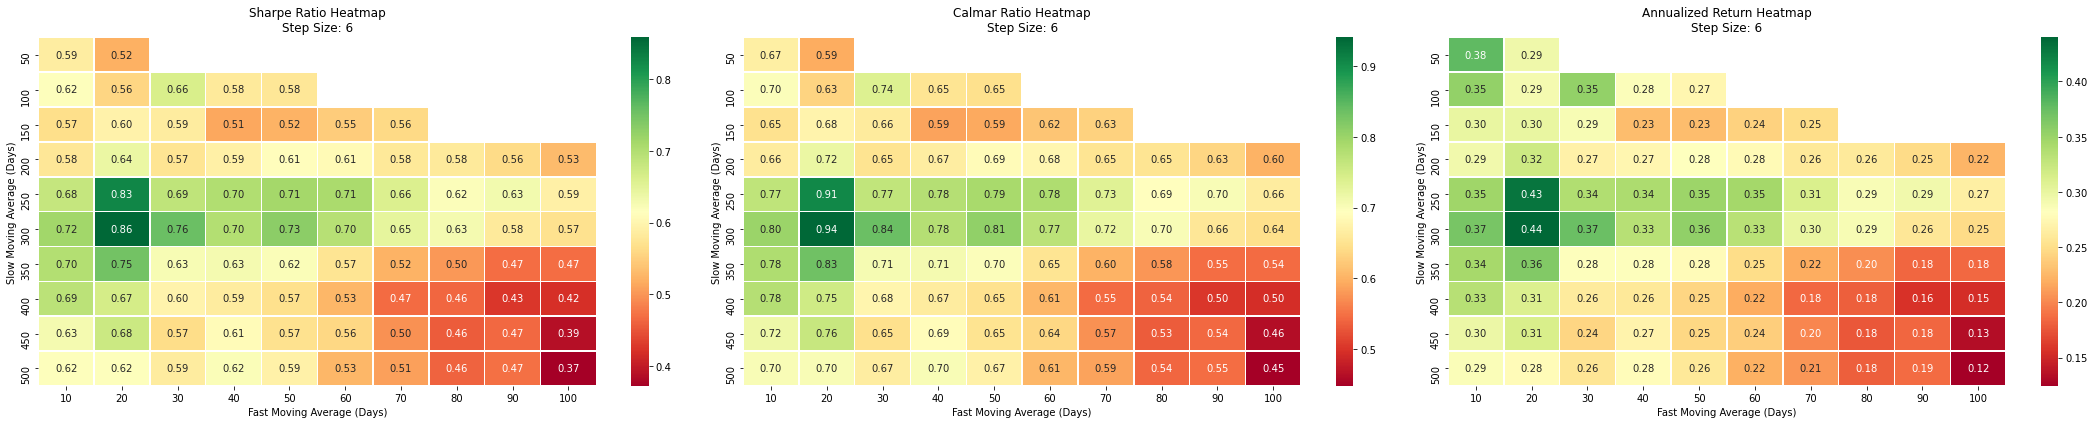

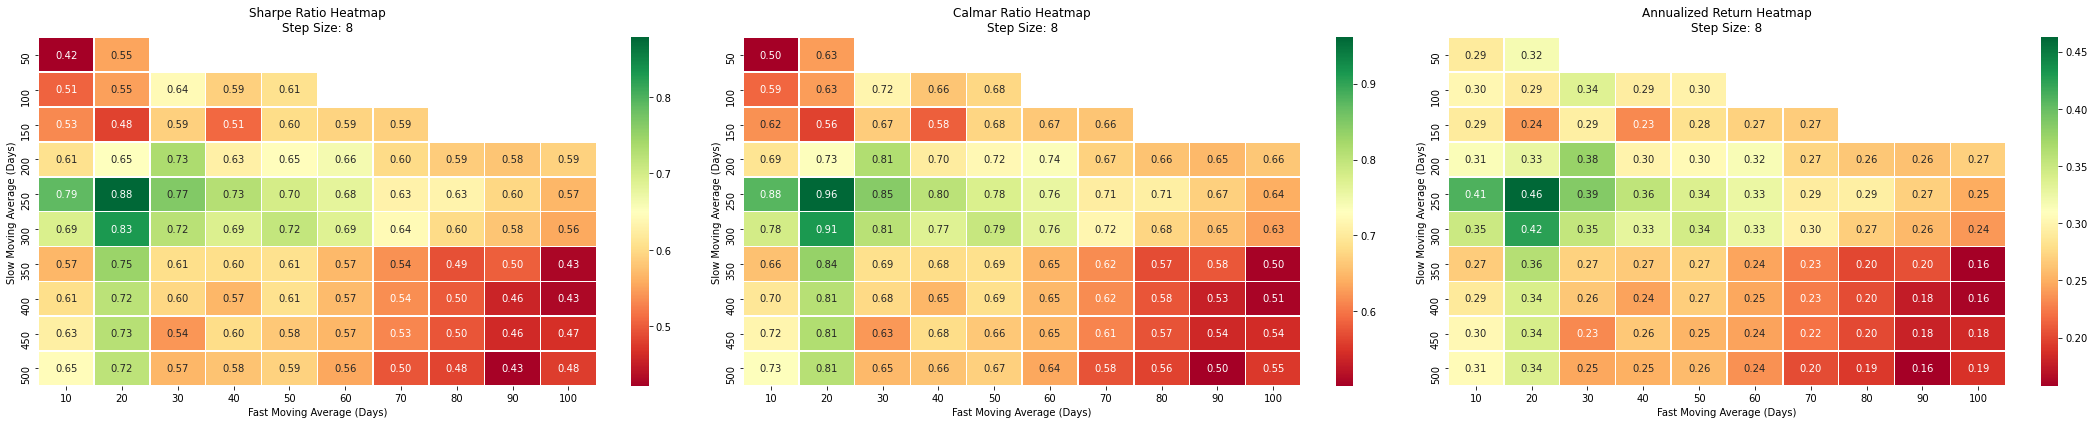

In [77]:
plot_moving_avg_crossover_performance(df_performance_price)

## Keltner Channels

In [78]:
data = load_financial_data(start_date, end_date, ticker)
data.head()

File not found...downloading the BTC-USD data
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
def calculate_keltner_channels(start_date, end_date, ticker, price_or_returns_calc='returns', rolling_atr_window=20, upper_atr_multiplier=2, lower_atr_multiplier=2):
    
    df = load_financial_data(start_date, end_date, ticker, print_status=False)
    df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
    
    if price_or_returns_calc == 'price':
        # Calculate the Exponential Moving Average (EMA)
        df['EMA'] = df['Close'].ewm(span=n, adjust=False).mean()

        # Calculate the True Range (TR) and Average True Range (ATR)
        df['High-Low'] = df['High'] - df['Low']
        df['High-Close'] = np.abs(df['High'] - df['Close'].shift(1))
        df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift(1))
        df['True Range'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
        df['ATR'] = df['True Range'].rolling(window=n).mean()

        # Calculate the Upper and Lower Bands
        df['Upper Band'] = df['EMA'] + (df['ATR'] * atr_multiplier)
        df['Lower Band'] = df['EMA'] - (df['ATR'] * atr_multiplier)
        

In [ ]:
def keltner_channels(df, n=20, atr_multiplier=2):
    # Calculate the Exponential Moving Average (EMA)
    df['EMA'] = df['Close'].ewm(span=n, adjust=False).mean()
    
    # Calculate the True Range (TR) and Average True Range (ATR)
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['True Range'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['ATR'] = df['True Range'].rolling(window=n).mean()
    
    # Calculate the Upper and Lower Bands
    df['Upper Band'] = df['EMA'] + (df['ATR'] * atr_multiplier)
    df['Lower Band'] = df['EMA'] - (df['ATR'] * atr_multiplier)
    
    return df

## Correlation of Signals

In [ ]:
# short_mavg_window = [10,20,10,20,30,30,40,50,100,90]
# long_mavg_window = [100,200,100,200,300,300,400,500,1000,900]
short_mavg_window = [10, 50, 100, 200]
long_mavg_window = [50, 100, 200, 500]
mavg_stepsize_list = [2,4]

In [ ]:
print(len(short_mavg_window))
print(len(long_mavg_window))
print(len(mavg_stepsize_list))

In [ ]:
# Create a date range
date_range = pd.date_range(start=start_date, end=end_date)

# Create an empty DataFrame with the date_range as the index
df_returns = pd.DataFrame(index=date_range)

In [ ]:
ticker = 'BTC-USD'
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2023, 12, 31)

for i in np.arange(0,4):
    print(i)
    mavg_start = short_mavg_window[i]
    mavg_end = long_mavg_window[i]
    for mavg_stepsize in mavg_stepsize_list:
#         print(mavg_stepsize)
#         mavg_stepsize = mavg_stepsize_list[i]
        data = get_close_prices(start_date, end_date, ticker)
        data = (create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, slope_window=10, moving_avg_type='exponential', price_or_returns_calc='returns')
                .rename(columns={'BTC-USD_trend_slope_strategy_returns': f'BTC-USD_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}'}))
        df_returns = pd.merge(df_returns, data[[f'BTC-USD_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}']], left_index=True, right_index=True, how='left')

df_returns = df_returns.dropna()

In [ ]:
ticker = 'BTC-USD'
data = get_close_prices(start_date, end_date, ticker)
data[f'{ticker}_pct_returns'] = data[f'{ticker}'].pct_change()
df_returns = pd.merge(df_returns, data[f'{ticker}_pct_returns'], left_index=True, right_index=True, how='left')

In [ ]:
ticker = '^GSPC'
data = get_close_prices(start_date, end_date, ticker)
data[f'{ticker}_pct_returns'] = data[f'{ticker}'].pct_change()
df_returns = pd.merge(df_returns, data[f'{ticker}_pct_returns'], left_index=True, right_index=True, how='left')

In [ ]:
data.head()

In [ ]:
data.tail()

In [ ]:
df_returns.tail(200)

In [ ]:
mavg_corr_matrix = df_returns.corr()

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(mavg_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Signal Returns')
plt.show()

In [ ]:
df_results_returns_t_cost.index.names = ['strategy']
df_results_returns_t_cost[df_results_returns_t_cost.index.get_level_values('strategy').str.startswith('BTC-USD')].sort_values('annualized_sharpe_ratio', ascending=False)

In [ ]:
data[f'{ticker}_trend_strategy_trades'] = data[f'{ticker}_trend_signal'].diff()
data[f'{ticker}_trend_slope_strategy_trades'] = data[f'{ticker}_trend_slope_signal'].diff()

In [ ]:
df_tsla = get_close_prices(start_date, end_date, ticker='TSLA')

In [ ]:
df_tsla.head()

In [ ]:
len(ticker)

In [ ]:
data.head(10)

In [ ]:
ticker = ['SPY']
data_SPY = get_close_prices(start_date, end_date, ticker=ticker)

In [ ]:
data_SPY.head(10)

In [ ]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2015, 1, 1)
end_date = pd.datetime(2024, 7, 21)
ticker = ['PL=F']
data = get_close_prices(start_date, end_date, ticker=ticker)

In [ ]:
data.head()

In [ ]:
mavg_start_list = [mavg_start for mavg_start in np.arange(10,110,10)]
mavg_start_list

In [ ]:
# def get_mavg_windows_trim():
#     mavg_list = []
#     _mavg = []
#     mavg_start_list = [mavg_start for mavg_start in np.arange(10,110,10)]
#     mavg_end_list = [mavg_end for mavg_end in np.arange(100,1100,100)]
#     for i in np.arange(0,10,1):
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], 2])
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], 4])
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], 10])
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], int(mavg_start_list[i] - mavg_start_list[i]/10+1)])
    
#     mavg_list = pd.DataFrame(mavg_list).drop_duplicates().values.tolist()
    
#     return mavg_list

In [ ]:
def get_mavg_windows():
    mavg_list = []
    _mavg = []
    mavg_start_list = [mavg_start for mavg_start in np.arange(10,110,10)]
    mavg_end_list = [mavg_end for mavg_end in np.arange(100,1100,100)]
    for i in np.arange(0,10,1):
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 2])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 4])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 10])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], int(mavg_start_list[i] - mavg_start_list[i]/10+1)])
    
    mavg_list = pd.DataFrame(mavg_list).drop_duplicates().values.tolist()
    
    return mavg_list

In [ ]:
def get_mavg_windows_trim():
    mavg_list = []
    _mavg = []
#     mavg_start_list = [mavg_start for mavg_start in np.arange(10,110,10)]
#     mavg_end_list = [mavg_end for mavg_end in np.arange(100,1100,100)]
    mavg_start_list = [10, 50, 100, 200]
    mavg_end_list = [50, 100, 200, 500]
#     mavg_stepsize_list = [2,4]
    for i in np.arange(0,4,1):
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 2])
        mavg_list.append([mavg_start_list[i], mavg_end_list[i], 4])
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], 10])
#         mavg_list.append([mavg_start_list[i], mavg_end_list[i], int(mavg_start_list[i] - mavg_start_list[i]/10+1)])
    
    mavg_list = pd.DataFrame(mavg_list).drop_duplicates().values.tolist()
    
    return mavg_list

In [ ]:
get_mavg_windows_trim()

In [ ]:
def get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='simple', price_or_returns_calc='price', annual_trading_days=252, include_transaction_costs_and_fees=True,
                                 transaction_cost_est=0.001, passive_trade_rate=0.5):
    if isinstance(ticker_list, str):
        ticker_list = [ticker_list]
#     mavg_list = get_mavg_windows()
    mavg_list = get_mavg_windows_trim()
    performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown',
                           'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    final_perf_stats = []
    
    for ticker in ticker_list:
        print(ticker)
        df_temp_results = pd.DataFrame(columns=performance_columns)
        for mavg_start, mavg_end, mavg_stepsize in mavg_list:
            print(mavg_start, mavg_end, mavg_stepsize)
            df = get_close_prices(start_date, end_date, ticker)
            df = create_trend_strategy(df, ticker, mavg_start, mavg_end, mavg_stepsize, slope_window=5, moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc)
            if (df.shape[0] > 100) & ((df[f'{ticker}_trend_strategy_returns'] != 0).any()):
                trend_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'{ticker}_trend_strategy_returns',
                                                                      strategy_trade_count_col=f'{ticker}_trend_strategy_trades',annual_trading_days=annual_trading_days,
                                                                            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                                                            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
                df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
            if (df.shape[0] > 100) & ((df[f'{ticker}_trend_slope_strategy_returns'] != 0).any()):
                trend_slope_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns',
                                                                            strategy_trade_count_col=f'{ticker}_trend_slope_strategy_trades', annual_trading_days=annual_trading_days,
                                                                            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
                                                                            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate)
                df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_slope_strategy_returns'] = trend_slope_metrics
        final_perf_stats.append(df_temp_results)

    df_results = pd.concat(final_perf_stats, axis=0)
    
    return df_results

In [ ]:
ticker_list = ['ETH-USD','SOL-USD','XRP-USD','BTC-USD']#,'ADA-USD','DOT-USD'
df_results_returns_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='returns', annual_trading_days=365, include_transaction_costs_and_fees=True)
df_results_returns_no_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='returns', annual_trading_days=365, include_transaction_costs_and_fees=False)
# df_results_price_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='price', annual_trading_days=365, include_transaction_costs_and_fees=True)
# df_results_price_no_t_cost = get_mavg_strategy_performance(start_date, end_date, ticker_list, moving_avg_type='exponential', price_or_returns_calc='price', annual_trading_days=365, include_transaction_costs_and_fees=False)

In [ ]:
df_results_returns_t_cost.sort_values('annualized_sharpe_ratio', ascending=False)

In [ ]:
df_results_price_t_cost.sort_values('annualized_sharpe_ratio', ascending=False)

## Rolling Sharpe Ratio

In [ ]:
def rolling_sharpe_ratio(df, window, strategy_daily_return_col, strategy_trade_count_col, **kwargs):
    def sharpe_on_window(window_df):
        # Calculate the Sharpe ratio on the windowed data frame
        return sharpe_ratio(window_df, strategy_daily_return_col, strategy_trade_count_col, **kwargs)

    # Apply the function over a rolling window and return as a Series (not a full DataFrame)
    rolling_sharpe = df[strategy_daily_return_col].rolling(window=window).apply(
        lambda x: sharpe_on_window(df.loc[x.index]), raw=False
    )
    
    # Add the rolling Sharpe ratio as a new column in the original DataFrame
    df[f'rolling_sharpe_{window}'] = rolling_sharpe
    
    return df

In [ ]:
# short_mavg_window = [10,20,10,20,30,30,40,50,100,90]
# long_mavg_window = [100,200,100,200,300,300,400,500,1000,900]
short_mavg_window = [10, 50, 100, 200]
long_mavg_window = [50, 100, 200, 500]
mavg_stepsize_list = [2,4]

In [ ]:
print(len(short_mavg_window))
print(len(long_mavg_window))
print(len(mavg_stepsize_list))

In [ ]:
# Create a date range
date_range = pd.date_range(start=start_date, end=end_date)

# Create an empty DataFrame with the date_range as the index
df_returns = pd.DataFrame(index=date_range)

In [ ]:
ticker = 'BTC-USD'
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2024, 7, 30)

for i in np.arange(0,4):
    print(i)
    mavg_start = short_mavg_window[i]
    mavg_end = long_mavg_window[i]
    for mavg_stepsize in mavg_stepsize_list:
#         print(mavg_stepsize)
#         mavg_stepsize = mavg_stepsize_list[i]
        data = get_close_prices(start_date, end_date, ticker)
        data = (create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')
                .rename(columns={'BTC-USD_trend_slope_strategy_returns': f'BTC-USD_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}',
                                 'BTC-USD_trend_slope_strategy_trades': f'BTC-USD_trend_slope_strategy_trades_{mavg_start}_{mavg_stepsize}_{mavg_end}'}))
        df_returns = pd.merge(df_returns, data[[f'BTC-USD_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}', f'BTC-USD_trend_slope_strategy_trades_{mavg_start}_{mavg_stepsize}_{mavg_end}']],
                              left_index=True, right_index=True, how='left')

df_returns = df_returns.dropna()

In [ ]:
df_returns.shape

In [ ]:
df_returns.tail(200)

In [ ]:
# # ticker = 'ETH-USD'
# ticker = 'BTC-USD'
# data = get_close_prices(start_date, end_date, ticker)
# mavg_start = 100
# mavg_end = 200
# mavg_stepsize = 4
# data = create_trend_strategy(data, ticker, mavg_start, mavg_end, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns')

In [ ]:
# # Example usage:
# window = 180 # 1 year rolling window assuming 252 trading days in a year
# rolling_sharpe = rolling_sharpe_ratio(data, window, strategy_daily_return_col='BTC-USD_trend_slope_strategy_returns', strategy_trade_count_col='BTC-USD_trend_slope_strategy_trades')

In [ ]:
window = 180
for i in np.arange(0,3):
    mavg_start = short_mavg_window[i]
    mavg_end = long_mavg_window[i]
    for mavg_stepsize in mavg_stepsize_list:
        print(mavg_start, mavg_end, mavg_stepsize)
        df_returns = rolling_sharpe_ratio(df_returns, window, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}',
                                          strategy_trade_count_col=f'{ticker}_trend_slope_strategy_trades_{mavg_start}_{mavg_stepsize}_{mavg_end}')
        df_returns = df_returns.rename(columns={f'rolling_sharpe_{window}': f'{ticker}_{mavg_start}_{mavg_stepsize}_{mavg_end}_rolling_{window}_sharpe'})

In [ ]:
ticker = 'BTC-USD'
data = get_close_prices(start_date, end_date, ticker)
data[f'{ticker}_pct_returns'] = data[f'{ticker}'].pct_change()
df_returns = pd.merge(df_returns, data, left_index=True, right_index=True, how='left')

In [ ]:
data.head()

In [ ]:
df_returns.tail()

In [ ]:
for i in np.arange(0,3):
    mavg_start = short_mavg_window[i]
    mavg_end = long_mavg_window[i]
    for mavg_stepsize in mavg_stepsize_list:
        fig = plt.figure(figsize=(22,6))
        # plt.style.use('bmh')
        layout = (1,2)
        price_return_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        rolling_performance_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        
        _ = price_return_ax.plot(df_returns.index, df_returns[f'{ticker}'], label=f'{ticker} Close Price', color='blue')
        price_return_ax_2 = price_return_ax.twinx()
        _ = price_return_ax_2.plot(df_returns.index, df_returns[f'{ticker}_pct_returns'].rolling(window).mean(), label=f'{ticker} Returns', color='orange')

        _ = rolling_performance_ax.plot(df_returns.index, df_returns[f'{ticker}_{mavg_start}_{mavg_stepsize}_{mavg_end}_rolling_{window}_sharpe'], label=f'Sharpe', color='green')
        rolling_performance_ax_2 = rolling_performance_ax.twinx()
        _ = rolling_performance_ax_2.plot(df_returns.index, df_returns[f'{ticker}_trend_slope_strategy_returns_{mavg_start}_{mavg_stepsize}_{mavg_end}'].rolling(90).mean(),
                                          label='Strategy Returns', color='magenta')

        _ = price_return_ax.grid()
        _ = price_return_ax.legend(loc='upper left')
        _ = price_return_ax_2.legend(loc='upper right')
        _ = price_return_ax.set_title(f'{ticker} Price & Returns')
        # _ = rolling_sharpe.grid()
        _ = rolling_performance_ax.legend(loc='upper left')
        _ = rolling_performance_ax.grid()
        _ = rolling_performance_ax_2.legend(loc='upper right')
        _ = rolling_performance_ax_2.set_title(f'{ticker} {mavg_start}/{mavg_stepsize}/{mavg_end} Rolling Performance')
        # _ = momentum_ax_4.grid()
        # _ = momentum_ax_4.legend()
        # _ = momentum_ax_5.grid()
        # _ = momentum_ax_5.legend()
        # _ = momentum_ax_6.grid()
        # _ = momentum_ax_6.legend()

        plt.tight_layout()

## Combined Moving Average Signals

In [ ]:
ticker = 'BTC-USD'
data = get_close_prices(start_date, end_date, ticker)
short_mavg_window = [10, 50, 100, 200]
long_mavg_window = [50, 100, 200, 500]
mavg_stepsize_list = [2,4]

In [ ]:
for window in np.linspace(10, 50, 2):
    print(window)

In [ ]:
for i in np.arange(0,4):
    print(short_mavg_window[i])
    data = (create_trend_strategy(data, ticker, mavg_start=short_mavg_window[i], mavg_end=long_mavg_window[i], mavg_stepsize=2, moving_avg_type='exponential', price_or_returns_calc='returns')
            .rename(columns={'BTC-USD_ribbon_thickness':f'BTC-USD_ribbon_thickness_{short_mavg_window[i]}_{long_mavg_window[i]}_mavg',
                             'BTC-USD_trend_signal':f'BTC-USD_trend_signal_{short_mavg_window[i]}_{long_mavg_window[i]}_mavg',
                             'BTC-USD_trend_strategy_returns':f'BTC-USD_trend_strategy_returns_{short_mavg_window[i]}_{long_mavg_window[i]}_mavg',
                             'BTC-USD_trend_strategy_trades':f'BTC-USD_trend_strategy_trades_{short_mavg_window[i]}_{long_mavg_window[i]}_mavg',
                             'BTC-USD_trend_slope_signal':f'BTC-USD_trend_slope_signal_{short_mavg_window[i]}_{long_mavg_window[i]}_mavg',
                             'BTC-USD_trend_slope_strategy_returns':f'BTC-USD_trend_slope_strategy_returns_{short_mavg_window[i]}_{long_mavg_window[i]}_mavg',
                             'BTC-USD_trend_slope_strategy_trades':f'BTC-USD_trend_slope_strategy_trades_{short_mavg_window[i]}_{long_mavg_window[i]}_mavg'}))

In [ ]:
data = (create_trend_strategy(data, ticker, mavg_start=10, mavg_end=100, mavg_stepsize=2, moving_avg_type='exponential', price_or_returns_calc='returns')
        .rename(columns={'BTC-USD_ribbon_thickness':'BTC-USD_ribbon_thickness_10_100_mavg','BTC-USD_trend_signal':'BTC-USD_trend_signal_10_100_mavg', 'BTC-USD_trend_strategy_returns':'BTC-USD_trend_strategy_returns_10_100_mavg',
                        'BTC-USD_trend_strategy_trades':'BTC-USD_trend_strategy_trades_10_100_mavg','BTC-USD_trend_slope_signal':'BTC-USD_trend_slope_signal_10_100_mavg','BTC-USD_trend_slope_strategy_returns':'BTC-USD_trend_slope_strategy_returns_10_100_mavg',
                        'BTC-USD_trend_slope_strategy_trades':'BTC-USD_trend_slope_strategy_trades_10_100_mavg'}))
data = (create_trend_strategy(data, ticker, mavg_start=30, mavg_end=300, mavg_stepsize=2, moving_avg_type='exponential', price_or_returns_calc='returns')
        .rename(columns={'BTC-USD_ribbon_thickness':'BTC-USD_ribbon_thickness_30_300_mavg','BTC-USD_trend_signal':'BTC-USD_trend_signal_30_300_mavg', 'BTC-USD_trend_strategy_returns':'BTC-USD_trend_strategy_returns_30_300_mavg',
                        'BTC-USD_trend_strategy_trades':'BTC-USD_trend_strategy_trades_30_300_mavg','BTC-USD_trend_slope_signal':'BTC-USD_trend_slope_signal_30_300_mavg','BTC-USD_trend_slope_strategy_returns':'BTC-USD_trend_slope_strategy_returns_30_300_mavg',
                        'BTC-USD_trend_slope_strategy_trades':'BTC-USD_trend_slope_strategy_trades_30_300_mavg'}))

In [ ]:
## Combine the trend strategies
# Combine the two signals into one by averaging them
data['BTC-USD_combined_signal_10_100_30_300'] = (data['BTC-USD_trend_signal_10_100_mavg'] + data['BTC-USD_trend_signal_30_300_mavg']) / 2

# Round to get a signal of -1, 0, or 1
data['BTC-USD_combined_signal_10_100_30_300'] = np.sign(data['BTC-USD_combined_signal_10_100_30_300'])

# Get strategy returns
data['BTC-USD_combined_10_100_30_300_strategy_returns'] = data['BTC-USD_combined_signal_10_100_30_300'].shift(1) * data['BTC-USD_pct_returns']

# Get trade count
data['BTC-USD_combined_10_100_30_300_strategy_trades'] = data['BTC-USD_combined_signal_10_100_30_300'].diff()

In [ ]:
## Combine the slope strategies
# Combine the two signals into one by averaging them
data['BTC-USD_combined_slope_signal_10_100_30_300'] = (data['BTC-USD_trend_slope_signal_10_100_mavg'] + data['BTC-USD_trend_slope_signal_30_300_mavg']) / 2

# Round to get a signal of -1, 0, or 1
data['BTC-USD_combined_slope_signal_10_100_30_300'] = np.sign(data['BTC-USD_combined_slope_signal_10_100_30_300'])

# Get strategy returns
data['BTC-USD_combined_slope_10_100_30_300_strategy_returns'] = data['BTC-USD_combined_slope_signal_10_100_30_300'].shift(1) * data['BTC-USD_pct_returns']

# Get trade count
data['BTC-USD_combined_slope_10_100_30_300_strategy_trades'] = data['BTC-USD_combined_slope_signal_10_100_30_300'].diff()

In [ ]:
data[['BTC-USD_10_mavg','BTC-USD_100_mavg','BTC-USD_trend_signal_10_100_mavg','BTC-USD_trend_signal_30_300_mavg','BTC-USD_10_mavg_slope','BTC-USD_100_mavg_slope','BTC-USD_trend_slope_signal_10_100_mavg','BTC-USD_trend_slope_signal_30_300_mavg','BTC-USD_combined_signal_10_100_30_300','BTC-USD_combined_slope_signal_10_100_30_300']]

In [ ]:
trend_metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col='BTC-USD_combined_10_100_30_300_strategy_returns',
                                                                      strategy_trade_count_col=f'BTC-USD_combined_10_100_30_300_strategy_trades',annual_trading_days=365,
                                                                            include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)

In [ ]:
trend_metrics

In [ ]:
trend_metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col='BTC-USD_combined_slope_10_100_30_300_strategy_returns',
                                                                      strategy_trade_count_col=f'BTC-USD_combined_slope_10_100_30_300_strategy_trades',annual_trading_days=365,
                                                                            include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)

In [ ]:
trend_metrics

In [ ]:
trend_metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col='BTC-USD_trend_slope_strategy_returns_10_100_mavg',
                                                                      strategy_trade_count_col=f'BTC-USD_trend_slope_strategy_trades_10_100_mavg',annual_trading_days=365,
                                                                            include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)

In [ ]:
trend_metrics

In [ ]:
trend_metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col='BTC-USD_trend_slope_strategy_returns_30_300_mavg',
                                                                      strategy_trade_count_col=f'BTC-USD_trend_slope_strategy_trades_30_300_mavg',annual_trading_days=365,
                                                                            include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5)

In [ ]:
trend_metrics

In [ ]:
data.head(50)

In [ ]:
ticker = 'BTC-USD'
mavg_start = 10
mavg_end = 100
mavg_stepsize = 2
df_temp_results = pd.DataFrame(columns=performance_columns)
df_test = get_close_prices(start_date, end_date, ticker)
df_test = create_trend_strategy(df_test, ticker, mavg_start, mavg_end, mavg_stepsize)
# df_test['BTC-USD_trend_signal_test'] = df_test['BTC-USD_trend_signal'].shift(1)
# df_test['BTC-USD_trend_strategy_returns_test'] = df_test['BTC-USD_trend_signal_test'] * df_test['BTC-USD_pct_returns']
# df_test = df_test.dropna()
if (df_test.shape[0] > 100) & ((df_test[f'{ticker}_trend_strategy_returns'] != 0).any()):
    trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns')
    df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
if (df_test.shape[0] > 100) & ((df_test[f'{ticker}_trend_slope_strategy_returns'] != 0).any()):
    trend_slope_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns')
                
# trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns')
# df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_strategy_returns'] = trend_metrics
# trend_metrics = calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_slope_strategy_returns')
# df_temp_results.loc[f'{ticker}_{mavg_start}-{mavg_end}-{mavg_stepsize}_trend_slope_strategy_returns'] = trend_metrics

In [ ]:
df_test.shape

In [ ]:
df_temp_results

In [ ]:
calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col=f'{ticker}_trend_strategy_returns_test')

In [ ]:
df_test[['BTC-USD','BTC-USD_pct_returns','BTC-USD_trend_slope_signal','BTC-USD_trend_strategy_returns']].head(1000)

In [ ]:
df_test.tail(200)

In [ ]:
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    print(window)

In [ ]:
df_test#.shape

In [ ]:
df_test.head()

In [ ]:
ticker_list = ['BCH-USD','ETH-USD','XRP-USD','SOL-USD','BTC-USD']
df_mavg_results = get_mavg_strategy_performance(start_date, end_date, ticker_list)

In [ ]:
ticker_list = ['BCH-USD','ETH-USD','XRP-USD','SOL-USD','BTC-USD']
momentum_strategy_list = ['10_day_momentum','1_month_momentum','3_month_momentum','6_month_momentum','12_month_momentum','12_month_minus_1_month_momentum']
threshold_list = [0.2] * len(momentum_strategy_list)
performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value']
final_perf_stats = []
for ticker in ticker_list:
    print(ticker)
    df_temp_results = pd.DataFrame(columns=performance_columns)
    for i in np.arange(len(momentum_strategy_list)):
        data = get_close_prices(start_date, end_date, ticker)
        data = get_long_and_short_term_momentum(data, close_px_col=ticker, returns_type='logarithmic', weekend_trading=True)
        data[f'{ticker}_12_month_minus_1_month_momentum'] = data[f'{ticker}_12_month_momentum'] - data[f'{ticker}_1_month_momentum']
        data = generate_momentum_signal(data, ticker=ticker, momentum_type=momentum_strategy_list[i], threshold=threshold_list[i])
        data = data.dropna()
        metrics = calculate_risk_and_performance_metrics(data, strategy_daily_return_col=f'{ticker}_{momentum_strategy_list[i]}_strategy_returns')
        df_temp_results.loc[f'{ticker}_{momentum_strategy_list[i]}_strategy_returns'] = metrics
    
    final_perf_stats.append(df_temp_results)

df_final = pd.concat(final_perf_stats, axis=0)

In [ ]:
mavg_list = get_mavg_windows()
mavg_list

In [ ]:
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
df_results = get_strategy_performance(start_date, end_date, ticker)

In [ ]:
df_test.head()

In [ ]:
fig = plt.figure(figsize=(15,8))
# plt.style.use('bmh')
layout = (1,2)
sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
pnl_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

mavg_cond = (df_results.mavg_start == 10) & (df_results.mavg_end == 100) & (df_results.mavg_stepsize == 4)
_ = sharpe_ax.plot(df_results[mavg_cond].ticker, df_results[mavg_cond]['sharpe_ratio'])
_ = sharpe_ax.grid()
_ = pnl_ax.plot(df_results[mavg_cond].ticker, df_results[mavg_cond]['pnl'])
_ = pnl_ax.grid()

plt.tight_layout()

In [ ]:
df_results[mavg_cond]

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results_ETH = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')
    _pnl = data[f'ETH-USD_mavg_trend_PnL'].sum()
    results_ETH.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_ETH

In [ ]:
## Simple Moving Average Results
results_ETH = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')
    _pnl = data[f'ETH-USD_mavg_trend_PnL'].sum()
    results_ETH.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_ETH

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['PL=F','ES=F']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='ES=F', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='ES=F_trend_strategy_returns', trade_col='ES=F_trend_trade')
    _pnl = data[f'ES=F_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
ticker = ['PL=F','ES=F']
data = load_financial_data(start_date, end_date, ticker=ticker)
data = data['Adj Close']
# data = create_trend_stra.tegy(data, ticker='PL=F', mavg_start=10, mavg_end=100, mavg_stepsize=4)

In [ ]:
fig = plt.figure(figsize=(15,8))
# plt.style.use('bmh')
layout = (1,2)
pl_prices_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
es_prices_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)

_ = pl_prices_ax.plot(data.index, data['PL=F'])
_ = es_prices_ax.plot(data.index, data['ES=F'])

plt.tight_layout()

In [ ]:
mavg_end

In [ ]:
data.tail(500)

In [ ]:
ticker = 'ES=F'
moving_avg_type='simple'
for window in np.linspace(10, 100, 4):
    if moving_avg_type == 'simple':
        data[f'{ticker}_{int(window)}_mavg'] = data[f'{ticker}'].rolling(int(window)).mean()
    else:
        data[f'{ticker}_{int(window)}_mavg'] = data[f'{ticker}'].ewm(span=window).mean()
    data[f'{ticker}_{int(window)}_mavg_slope'] = calculate_slope(data, column=f'{ticker}_{int(window)}_mavg',
                                                               periods=window)

In [ ]:
data.tail(500)

In [ ]:
results

In [ ]:
## Simple Moving Average Results
results = []
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data['Adj Close']
    data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, moving_avg_type='ewm')
    _sharpe = sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')
    _pnl = data[f'BTC-USD_mavg_trend_PnL'].sum()
    results.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results

In [ ]:
data = load_financial_data(start_date, end_date, ticker=ticker)

In [ ]:
data.head()

In [ ]:
results_SPY = []
ticker = ['SPY']
for mavg_start, mavg_end, mavg_stepsize in mavg_list:
    print(mavg_start, mavg_end, mavg_stepsize)
    data = load_financial_data(start_date, end_date, ticker=ticker)
    data = data[['Adj Close']].rename(columns={'Adj Close': 'SPY'})
    data = create_trend_strategy(data, ticker='SPY', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)
    _sharpe = sharpe_ratio(data, return_col='SPY_trend_strategy_returns', trade_col='SPY_trend_trade')
    _pnl = data[f'SPY_mavg_trend_PnL'].sum()
    results_SPY.append([mavg_start, mavg_end, mavg_stepsize, round(_sharpe,2), round(_pnl,2)])

In [ ]:
results_SPY

In [ ]:
mavg_start = 10
mavg_end = 50
mavg_stepsize = 4
slope_window = 10

In [ ]:
# ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
# ticker = ['PL=F','ES=F']
ticker = ['BTC-USD']
# start_date = pd.datetime(2015, 1, 1)
# end_date = pd.datetime(2024, 7, 31)
data = get_close_prices(start_date, end_date, ticker)
data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize, slope_window=10, moving_avg_type='exponential', price_or_returns_calc='returns')

In [ ]:
data.head()

In [ ]:
sharpe_ratio(data, strategy_daily_return_col='BTC-USD_trend_slope_strategy_returns', strategy_trade_count_col='BTC-USD_trend_slope_strategy_trades')

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

data = data[(data.index.get_level_values('Date') >= '2020-01-01') & (data.index.get_level_values('Date') <= '2021-01-01')]
# _ = mavg_ax.plot(data.index, data['BTC-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
# _ = mavg_ax.plot(data.index, data['BTC-USD_pct_returns'], label='Returns', linestyle='--', color='red', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax2.plot(data.index, data[f'BTC-USD_{int(window)}_mavg_slope'], label=f'{int(window)} MAVG', linestyle='--')
    
# buy_cond = (data['BTC-USD_trend_slope_signal_diff'] == 1)
# sell_cond = (data['BTC-USD_trend_slope_signal_diff'] == -1)
# _ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
# _ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'BTC-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

# pnl_cond = (data['BTC-USD_trend_slope_trade'].notnull())
# _ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['BTC-USD_mavg_trend_slope_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['BTC-USD_trend_slope_slope_signal'] == 1)
# sell_cond = (data['BTC-USD_trend_slope_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax2.legend(ncol=4)
_ = mavg_ax.set_title('BTC')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('BTC Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('BTC Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('BTC Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('BTC Cumulative P&L')

plt.tight_layout()

In [ ]:
data['BTC-USD_mavg_trend_PnL'].sum()

In [ ]:
data.head()

In [ ]:
data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)

In [ ]:
sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')

In [ ]:
data[data['ETH-USD_trend_trade'].notnull()]

In [ ]:
mavg_start_SPY = 50
mavg_end_SPY = 200
mavg_stepsize_SPY = 2

In [ ]:
for window in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY):
    print(window)
    data_SPY[f'SPY_{window}_mavg'] = data_SPY['SPY'].rolling(int(window)).mean()
#     data_SPY[f'SPY_{window}_mavg_slope'] = (data_SPY[f'SPY_10.0_mavg'] - data_SPY[f'SPY_10.0_mavg'].shift(int(window)))/window
    data_SPY[f'SPY_{window}_mavg_slope'] = calculate_slope(data_SPY, column=f'SPY_{window}_mavg', periods=window)
    
data_SPY['SPY_ribbon_thickness'] = data_SPY[f'SPY_{float(mavg_start_SPY)}_mavg'] - data_SPY[f'SPY_{float(mavg_end_SPY)}_mavg']
data_SPY = get_returns_volatility(data_SPY, vol_range_list=[10, 20, 30, 60, 90], close_px_col='SPY')

## SPY Trend Signal and Trade
SPY_mavg_col_list = [f'SPY_{mavg}_mavg' for mavg in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY).tolist()]
SPY_mavg_slope_col_list = [f'SPY_{mavg}_mavg_slope' for mavg in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY).tolist()]
data_SPY['SPY_trend_signal'] = data_SPY[SPY_mavg_col_list].apply(trend_signal, axis=1)
data_SPY['SPY_trend_signal_diff'] = data_SPY['SPY_trend_signal'].diff().shift(1)
data_SPY['SPY_trend_trade'] = np.where(data_SPY['SPY_trend_signal_diff'] != 0, data_SPY['SPY'], np.nan)
data_SPY['SPY_trend_slope_signal'] = data_SPY[SPY_mavg_slope_col_list].apply(slope_signal, axis=1)
data_SPY['SPY_trend_slope_signal_diff'] = data_SPY['SPY_trend_slope_signal'].diff().shift(1)
data_SPY['SPY_trend_slope_trade'] = np.where(data_SPY['SPY_trend_slope_signal_diff'] != 0, data_SPY['SPY'], np.nan)
data_SPY['SPY_trend_strategy_returns'] = data_SPY[f'SPY_pct_returns'] * data_SPY['SPY_trend_signal_diff']
data_SPY['SPY_trend_slope_strategy_returns'] = data_SPY[f'SPY_pct_returns'] * data_SPY['SPY_trend_slope_signal_diff']
# data_SPY['SPY_trend_trade'] = np.where((np.abs(data_SPY['SPY_ribbon_thickness']) > 2000) &
#                                    (data_SPY['SPY_trend_signal_diff'] != 0), data_SPY['SPY_trend_signal_diff'], np.nan)

In [ ]:
data.shape

In [ ]:
data_SPY.shape

In [ ]:
# data = data.dropna()
# data = data[data.index.get_level_values('Date') >= '2018-12-14']
data_SPY = data_SPY[data_SPY.index.get_level_values('Date') >= '2019-06-14']

In [ ]:
data['BTC_mavg_slope_PnL'] = data['BTC_trend_slope_signal_diff'] * data['BTC_trend_slope_trade'] * -1
BTC_cols = [col for col in data.columns if (col.startswith('BTC')) & (col[-5:] == 'slope')]
BTC_cols.append('BTC_trend_slope_signal')
BTC_cols.append('BTC_trend_slope_signal_diff')
BTC_cols.append('BTC_mavg_slope_PnL')
BTC_cols.append('BTC-USD_pct_returns')
BTC_cols.append('BTC_trend_slope_strategy_returns')
cond = (data['BTC_trend_slope_signal_diff'] != 0)
data[cond][BTC_cols]

In [ ]:
data['BTC_mavg_trend_PnL'] = data['BTC_trend_signal_diff'] * data['BTC_trend_trade'] * -1
BTC_cols = [col for col in data.columns if (col.startswith('BTC')) & (col[-5:] == 'slope')]
BTC_cols.append('BTC_trend_signal')
BTC_cols.append('BTC_trend_signal_diff')
BTC_cols.append('BTC_mavg_trend_PnL')
BTC_cols.append('BTC-USD_pct_returns')
BTC_cols.append('BTC_trend_strategy_returns')
cond = (data['BTC_trend_trade'].notnull())
data[cond][BTC_cols]

In [ ]:
data['ETH_mavg_slope_PnL'] = data['ETH_trend_slope_signal_diff'] * data['ETH_trend_slope_trade'] * -1
ETH_cols = [col for col in data.columns if (col.startswith('ETH')) & (col[-5:] == 'slope')]
ETH_cols.append('ETH_trend_slope_signal')
ETH_cols.append('ETH_trend_slope_signal_diff')
ETH_cols.append('ETH_mavg_slope_PnL')
cond = (data['ETH_trend_slope_trade'].notnull())
data[cond][ETH_cols]

In [ ]:
data['ETH_mavg_trend_PnL'] = data['ETH_trend_signal_diff'] * data['ETH_trend_trade'] * -1
ETH_cols = [col for col in data.columns if (col.startswith('ETH')) & (col[-5:] == 'slope')]
ETH_cols.append('ETH_trend_signal')
ETH_cols.append('ETH_trend_signal_diff')
ETH_cols.append('ETH_mavg_trend_PnL')
cond = (data['ETH_trend_trade'].notnull())
data[cond][ETH_cols]

In [ ]:
data_SPY['SPY_mavg_trend_PnL'] = data_SPY['SPY_trend_signal_diff'] * data_SPY['SPY_trend_trade'] * -1
SPY_cols = [col for col in data_SPY.columns if (col.startswith('SPY')) & (col[-5:] == 'slope')]
SPY_cols.append('SPY_trend_signal')
SPY_cols.append('SPY_trend_signal_diff')
SPY_cols.append('SPY_mavg_trend_PnL')
cond = (data_SPY['SPY_trend_trade'].notnull())
data_SPY[cond][SPY_cols]

In [ ]:
# Calculate the mean and standard deviation of the strategy returns
# mean_strategy_return = data['strategy_return'].mean()
# std_strategy_return = data['strategy_return'].std()

# Calculate annualized Sharpe Ratio (assuming 252 trading days in a year)
N = 255 #255 trading days in a year
rf =0.05 #1% risk free rate
cond = (data['BTC_trend_trade'].notnull())
sharpes = sharpe_ratio(data[cond]['BTC_trend_strategy_returns'], N, rf)

In [ ]:
data.head()

In [ ]:
print(f"BTC-USD_mavg_trend_PnL: {data['BTC-USD_mavg_trend_PnL'].sum()}")
cond = (data['BTC-USD_trend_signal_diff'] != 0)
print(f"BTC-USD Trend Sharpe Ratio: {sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')}")
print(f"BTC-USD_mavg_slope_PnL: {data['BTC-USD_mavg_slope_PnL'].sum()}")
cond = (data['BTC-USD_trend_slope_signal_diff'] != 0)
print(f"BTC-USD Trend Slope Sharpe Ratio: {sharpe_ratio(data, return_col='BTC-USD_trend_slope_strategy_returns', trade_col='BTC-USD_trend_slope_trade')}")

In [ ]:
print(f"ETH-USD_mavg_trend_PnL: {data['ETH-USD_mavg_trend_PnL'].sum()}")
cond = (data['ETH-USD_trend_signal_diff'] != 0)
print(f"ETH-USD Trend Sharpe Ratio: {sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')}")
print(f"ETH-USD_mavg_slope_PnL: {data['ETH-USD_mavg_slope_PnL'].sum()}")
cond = (data['ETH-USD_trend_slope_signal_diff'] != 0)
print(f"ETH-USD Trend Slope Sharpe Ratio: {sharpe_ratio(data, return_col='ETH-USD_trend_slope_strategy_returns', trade_col='ETH-USD_trend_slope_trade')}")

In [ ]:
[col for col in data_SPY.columns if (col.startswith('SPY')) & (col[-4:] == 'mavg')]

In [ ]:
data_SPY.loc[data_SPY.index >= '2020-03-01'][['SPY','SPY_50.0_mavg','SPY_200.0_mavg','SPY_trend_signal','SPY_trend_signal_diff','SPY_mavg_trend_PnL','SPY_ribbon_thickness']].head(500)

In [ ]:
data.loc[data.index >= '2022-05-01'][['BTC-USD','BTC_20.0_mavg','BTC_40.0_mavg','BTC_60.0_mavg','BTC_80.0_mavg','BTC_100.0_mavg','BTC_120.0_mavg','BTC_140.0_mavg',
                                      'BTC_160.0_mavg','BTC_180.0_mavg','BTC_200.0_mavg','BTC_trend_signal','BTC_trend_signal_diff','BTC_mavg_trend_PnL','BTC_ribbon_thickness']].head(500)

In [ ]:
data.loc[data['BTC-USD_trend_trade'].notnull()][['BTC-USD','BTC-USD_20_mavg','BTC-USD_40_mavg','BTC-USD_60_mavg','BTC-USD_80_mavg','BTC-USD_100_mavg','BTC-USD_120_mavg','BTC-USD_140_mavg',
                                      'BTC-USD_160_mavg','BTC-USD_180_mavg','BTC-USD_200_mavg','BTC-USD_trend_signal','BTC-USD_trend_signal_diff','BTC-USD_mavg_trend_PnL','BTC-USD_ribbon_thickness']].head(500)

In [ ]:
data_Pnl = data.loc[data['BTC-USD_trend_trade'].notnull()][['BTC-USD','BTC-USD_20_mavg','BTC-USD_40_mavg','BTC-USD_60_mavg','BTC-USD_80_mavg','BTC-USD_100_mavg','BTC-USD_120_mavg','BTC-USD_140_mavg',
                                      'BTC-USD_160_mavg','BTC-USD_180_mavg','BTC-USD_200_mavg','BTC-USD_trend_signal','BTC-USD_trend_signal_diff','BTC-USD_mavg_trend_PnL','BTC-USD_ribbon_thickness']].head(500)

In [ ]:
data_Pnl['BTC-USD_mavg_trend_PnL_cum'] = data_Pnl['BTC-USD_mavg_trend_PnL'].cumsum()

In [ ]:
data[data['BTC-USD_trend_trade'].notnull()].head(100)

In [ ]:
data['BTC-USD_ribbon_thickness_diff'] = data['BTC-USD_ribbon_thickness'].diff()

In [ ]:
data.index[3-1]

In [ ]:
data.head(500)

In [ ]:
for j in range(1, 4):
    print(j)

In [ ]:
data['BTC-USD_ribbon_thickness_signal'] = np.nan
data.loc[data.index[0:3], 'BTC-USD_ribbon_thickness_signal'] = 0
lookback_period = 3
for i in range(lookback_period, len(data)):
    if all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness'] > data.loc[data.index[i-j-1], 'BTC-USD_ribbon_thickness'] for j in range(0,lookback_period-1)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = 1
    elif all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness'] < data.loc[data.index[i-j-1], 'BTC-USD_ribbon_thickness'] for j in range(0,lookback_period-1)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = -1
#     elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal'] == 'Buy' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] < 0:
#         data['BTC-USD_ribbon_thickness_signal'] = 'Exit Buy'
#     elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal'] == 'Sell' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] > 0:
#         data['BTC-USD_ribbon_thickness_signal'] = 'Exit Sell'
    else:
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_signal'] = 0#data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_signal']

data['BTC-USD_ribbon_thickness_position'] = data['BTC-USD_ribbon_thickness_signal'].diff()
        
data['BTC-USD_ribbon_thickness_PnL'] = data['BTC-USD_ribbon_thickness_position'] * data['BTC-USD']
data['BTC-USD_ribbon_thickness_cum_PnL'] = data['BTC-USD_ribbon_thickness_PnL'].cumsum()

In [ ]:
trend_buy_signal = (data['BTC-USD_trend_signal'] == 1)
trend_sell_signal = (data['BTC-USD_trend_signal'] == -1)
ribbon_thickness_buy_signal = (data['BTC-USD_ribbon_thickness_signal'] == 1)
ribbon_thickness_sell_signal = (data['BTC-USD_ribbon_thickness_signal'] == -1)
data['BTC-USD_trend_ribbon_thickness_combo_signal'] = np.where(trend_buy_signal & ribbon_thickness_buy_signal, 1,
                                                              np.where(trend_sell_signal & ribbon_thickness_sell_signal, -1, 0))
data['BTC-USD_trend_ribbon_thickness_combo_position'] = data['BTC-USD_trend_ribbon_thickness_combo_signal'].diff()
data['BTC-USD_trend_ribbon_thickness_combo_PnL'] = data['BTC-USD_trend_ribbon_thickness_combo_position'] * data['BTC-USD']
data['BTC-USD_trend_ribbon_thickness_combo_cum_PnL'] = data['BTC-USD_trend_ribbon_thickness_combo_PnL'].cumsum()

In [ ]:
data['BTC-USD_trend_ribbon_thickness_combo_PnL'].sum()

In [ ]:
data[['BTC-USD','BTC-USD_ribbon_thickness','BTC-USD_ribbon_thickness_diff','BTC-USD_ribbon_thickness_signal','BTC-USD_trend_signal','BTC-USD_ribbon_thickness_position','BTC-USD_ribbon_thickness_PnL',
     'BTC-USD_ribbon_thickness_cum_PnL']].head(500)

In [ ]:
data['BTC-USD_ribbon_thickness_PnL'].sum()

In [ ]:
data['BTC-USD_ribbon_thickness_slope'] = calculate_slope(data, column='BTC-USD_ribbon_thickness', periods=50)
data['BTC-USD_ribbon_thickness_slope_diff'] = data['BTC-USD_ribbon_thickness_slope'].diff()
data['BTC-USD_ribbon_thickness_slope_position'] = np.nan
data.loc[data.index[0], 'BTC-USD_ribbon_thickness_slope_position'] = 'No Position'
for i in range(3, len(data)):
    if all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_slope_diff'] > 0 for j in range(1,4)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_slope_position'] = 'Buy'
    elif all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_slope_diff'] < 0 for j in range(1,4)):
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_slope_position'] = 'Sell'
    elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_slope_position'] == 'Buy' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] < 0:
        data['BTC-USD_ribbon_thickness_position'] = 'Exit Buy'
    elif data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_position'] == 'Sell' and data.loc[data.index[i], 'BTC-USD_ribbon_thickness_diff'] > 0:
        data['BTC-USD_ribbon_thickness_position'] = 'Exit Sell'
    else:
        data.loc[data.index[i], 'BTC-USD_ribbon_thickness_position'] = data.loc[data.index[i-1], 'BTC-USD_ribbon_thickness_position']
        
        

In [ ]:
data.head(100)

In [ ]:
np.abs(data['BTC-USD_trend_slope_signal_diff']).sum()

In [ ]:
ticker = 'BTC-USD'
data[f'{ticker}_trend_slope_signal_diff'] = data[f'{ticker}_trend_slope_signal'].diff().shift(1)
data[f'{ticker}_trend_slope_trade'] = np.where(data[f'{ticker}_trend_slope_signal_diff'] != 0, data[f'{ticker}'], 0)

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data.index, data['BTC-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
# _ = mavg_ax.plot(data.index, data['BTC-USD_pct_returns'], label='Returns', linestyle='--', color='red', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax2.plot(data.index, data[f'BTC-USD_{int(window)}_mavg_slope'], label=f'{int(window)} MAVG', linestyle='--')
    
buy_cond = (data['BTC-USD_trend_slope_signal_diff'] == 1)
sell_cond = (data['BTC-USD_trend_slope_signal_diff'] == -1)
_ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'BTC-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

# pnl_cond = (data['BTC-USD_trend_slope_trade'].notnull())
# _ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['BTC-USD_mavg_trend_slope_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['BTC-USD_trend_slope_slope_signal'] == 1)
# sell_cond = (data['BTC-USD_trend_slope_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('BTC')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('BTC Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('BTC Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('BTC Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('BTC Cumulative P&L')

plt.tight_layout()

## data['BTC-USD'].corr(data['BTC-USD_ribbon_thickness'])

In [ ]:
data['BTC-USD'].corr(data['BTC-USD_ribbon_thickness_slope'])

In [ ]:
data.iloc[i-0]['BTC-USD_ribbon_thickness_diff']

In [ ]:
all(data.loc[data.index[i-j], 'BTC-USD_ribbon_thickness_diff'] > 0 for j in range(1,4))

In [ ]:
data.loc[data.index[i-0], 'BTC-USD_ribbon_thickness_diff']# > 0 for j in range(1,4)

In [ ]:
data.loc[data.index[i:]]

In [ ]:
data#.shape

In [ ]:
data.groupby(['BTC-USD_ribbon_thickness_position']).size()

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data.index, data['ETH-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['ETH-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['ETH-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'ETH-USD_{int(window)}_mavg'], label=f'{int(window)} MAVG', linestyle='--')
    
buy_cond = (data['ETH-USD_trend_signal_diff'] == 1)
sell_cond = (data['ETH-USD_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['ETH-USD_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['ETH-USD_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'ETH-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['ETH-USD_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['ETH-USD_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
# _ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
# _ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

pnl_cond = (data['ETH-USD_trend_trade'].notnull())
_ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['ETH-USD_mavg_trend_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['ETH-USD_trend_slope_signal'] == 1)
# sell_cond = (data['ETH-USD_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['ETH-USD_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['ETH-USD_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('ETH')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('ETH Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('ETH Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4)
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('ETH Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('ETH Cumulative P&L')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (3,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data_SPY.index, data_SPY['SPY_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data_SPY.index, data_SPY['SPY_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data_SPY.index, data_SPY['SPY_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY):
    _ = mavg_ax.plot(data_SPY.index, data_SPY[f'SPY_{window}_mavg'], label=f'{window} MAVG', linestyle='--')
    
buy_cond = (data_SPY['SPY_trend_signal_diff'] == 1)
sell_cond = (data_SPY['SPY_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data_SPY[buy_cond].index, data_SPY[buy_cond]['SPY_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data_SPY[sell_cond].index, data_SPY[sell_cond]['SPY_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data_SPY.index, data_SPY[f'SPY_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data_SPY.index, data_SPY['SPY_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data_SPY.index, data_SPY['SPY_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data_SPY.index, data_SPY['SPY_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data_SPY.index, data_SPY['SPY_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data_SPY.index, data_SPY['SPY_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data_SPY['SPY_trend_slope_signal'] == 1)
# sell_cond = (data_SPY['SPY_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data_SPY[buy_cond].index, data_SPY[buy_cond]['SPY_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data_SPY[sell_cond].index, data_SPY[sell_cond]['SPY_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('SPY')

_ = slope_ax.grid()
_ = slope_ax.legend(ncol=4, loc='upper left')
_ = slope_ax2.legend(ncol=4, loc='upper right')
_ = slope_ax.set_title('SPY Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('SPY Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4)
_ = ribbon_vol_ax.set_title('SPY Ribbon Thickness')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta')
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax2.plot(data.index, data['BTC_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red')
# for window in np.linspace(10, 100, 10):
#     _ = mavg_ax.plot(data.index, data[f'BTC_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend(loc='upper left')
_ = mavg_ax2.legend(loc='upper right')
_ = mavg_ax.set_title('BTC')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

# _ = mavg_ax.plot(data.index, data['BTC_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=3)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'ETH_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=3)
_ = mavg_ax.set_title('ETH')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta')
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax2.plot(data.index, data['ETH_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red')
# for window in np.linspace(10, 100, 10):
#     _ = mavg_ax.plot(data.index, data[f'BTC_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend()
_ = mavg_ax.set_title('ETH')

plt.tight_layout()

In [ ]:
col_list = [col for col in data.columns if (col[:3] == 'BTC') & (col[-4:] == 'mavg')]

In [ ]:
data[col_list].head()

In [ ]:
data.head()

In [ ]:
window_list = [window for window in np.linspace(10, 100, 10)]
for i in np.arange(len(window_list)-1):
    print(i, window_list[i], window_list[i+1])
    data[f'signal_{window_list[i]}_{window_list[i+1]}'] = np.where(data[f'BTC_{window_list[i]}_mavg'] >
                                                                  data[f'BTC_{window_list[i+1]}_mavg'], 1, 0)

In [ ]:
data.head(100)

In [ ]:
data['signal'] = np.where(data['BTC_short_mavg'] > data['BTC_long_mavg'], 1, -1)

In [ ]:
short_mavg = asset.rolling(window=30, center=False).mean()
long_mavg = asset.rolling(window=200, center=False).mean()

asset[200:].plot(figsize=(15,7))
short_mavg[200:].plot()
long_mavg[200:].plot()
plt.ylabel('Price')
plt.show()